In [1]:
import sys
sys.path.append('/home/daniel/gitrepos/vision/references/detection')
sys.path.append('/home/daniel/gitrepos/models/object_detection/utils')
import os
import train_utils
import utils
import pandas as pd
from hparams import create_hparams
import torch
import torch.nn as nn
from PIL import Image, ImageFile
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
# import visualization_utils
import random
from matplotlib.pyplot import imshow
%matplotlib inline
hparams = create_hparams()

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]=["0","1"]
os.environ["CUDA_VISIBLE_DEVICES"]="1"

IMAGE_DIR = ""

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_csv = pd.read_csv(f"{hparams.csv_dir}/train-annotations-bbox.csv")
label_counts = train_csv["LabelName"].value_counts()
num_classes = len(label_counts)

In [3]:
# device = torch.device('cuda:1')
device = torch.device('cuda:0')

train_images_dir = "data/unzipped/all_train"
train_csv_file = "data/csvs/train-annotations-bbox-collapsed.csv"
model_ft = train_utils.get_instance_segmentation_model(num_classes)
model_ft.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
  

In [4]:
checkpoint = torch.load("checkpoints/checkpoint_0",map_location='cuda:0')

In [5]:
label_encoder = torch.load("checkpoints/label_encoder.bin")

In [6]:
model_ft.load_state_dict(checkpoint)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [7]:
# img_path = "data/unzipped/all_train/000002b66c9c498e.jpg"
activation = nn.Softmax(dim=1)
dataset_train = train_utils.OpenDataset(train_images_dir, train_csv_file, hparams.image_size, hparams.image_size, dataset_size=100,img_transforms=None)
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=8,
    collate_fn=utils.collate_fn)


100%|██████████| 100/100 [00:00<00:00, 8190.56it/s]


In [18]:
# del train_csv_file
num_print = 1
i = 2

all_targets = []
model_ft.eval()
with torch.no_grad():
    print(len(data_loader))
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        all_targets.extend(targets)
        
        output = model_ft(images)
#         output = activation(output)
        i += 1
        if i > num_print:
            break

50


In [20]:
# output[0]["labels"]
output[0]["boxes"][0]
# targets
# train_csv.head()
output[0]["scores"]

tensor([0.2451, 0.2212, 0.1937, 0.1442, 0.1399, 0.1125, 0.1025, 0.0977, 0.0964,
        0.0795, 0.0793, 0.0787, 0.0750, 0.0712, 0.0706, 0.0703, 0.0692, 0.0682,
        0.0644, 0.0639, 0.0634, 0.0624, 0.0600, 0.0590, 0.0567, 0.0561, 0.0561,
        0.0558, 0.0552, 0.0522, 0.0501], device='cuda:0')

In [12]:
label_csv = pd.read_csv(train_csv_file)
# label_csv.head()

In [13]:
# img_filename = "00001bcc92282a38.jpg"
target_idx = 0
image_idx = int(targets[target_idx]["image_id"])
img_filename = label_csv["ImageID"][image_idx] + ".jpg"
img_path = f"data/unzipped/all_train/{img_filename}"

target_labels = label_csv[label_csv["ImageID"] == img_filename.split(".")[0]]
target_labels

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,LabelEncoded
83,0000a1b2fba255e9,xclick xclick,/m/01g317 /m/09j2d,1 1,0.34 0.45375,0.6675 0.61,0.14 0.416667,0.823333 0.829167,1 0,0 0,0 0,0 0,0 0,67 430


In [14]:
label_descriptions = pd.read_csv("data/csvs/class-descriptions-boxable.csv", names=["id", "description"])
label_descriptions.head()

,id,description
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [15]:
target_labels = label_csv[label_csv["ImageID"] == img_filename.split(".")[0]]

for label_name in target_labels["LabelName"].values[0].split():
    print(label_name)
    print(label_descriptions[label_descriptions["id"] == label_name]["description"].values[0])
target_labels

/m/01g317
Person
/m/09j2d
Clothing


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,LabelEncoded
83,0000a1b2fba255e9,xclick xclick,/m/01g317 /m/09j2d,1 1,0.34 0.45375,0.6675 0.61,0.14 0.416667,0.823333 0.829167,1 0,0 0,0 0,0 0,0 0,67 430


<class 'numpy.ndarray'>
(128, 128, 3)


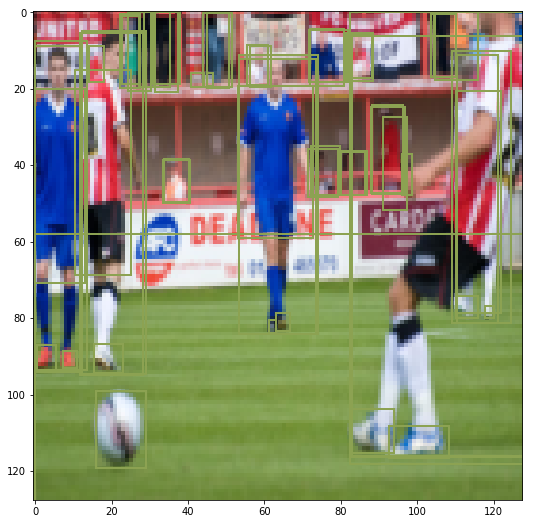

In [16]:
# img_path = "data/unzipped/all_train/000002b66c9c498e.jpg"
# img_filename = "00001bcc92282a38.jpg"
img_path = f"data/unzipped/all_train/{img_filename}"


img = Image.open(img_path)
i = 0
for images, targets in data_loader:
    if i > 0:
        break
    i += 1
target_idx = 0
img2 = images[target_idx].data.numpy()
img = np.swapaxes(img2,0,2)
img = np.swapaxes(img,0,1)
    
print(type(img))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
# img = np.array(img)
print(img.shape)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

img_size = 128
# img_size = 1024
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

for x1, y1, x2, y2 in targets[target_idx]["boxes"]:
# for x1, y1, x2, y2 in output[target_idx]["boxes"]:

    
#     box_h = ((y2 - y1) / unpad_h) * img.shape[0]
#     box_w = ((x2 - x1) / unpad_w) * img.shape[1]
#     y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
#     x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]

    box_h = (y2-y1) * img.shape[0]
    box_w = (x2-x1) * img.shape[1]
    y1 = y1 * img.shape[0]
    x1 = x1 * img.shape[1]
#     color = bbox_colors[int(np.where(
#          unique_labels == int(cls_pred))[0])]
    bbox = patches.Rectangle((x1, y1), box_w, box_h,
         linewidth=2, facecolor='none', edgecolor=colors[5])

#     bbox = patches.Rectangle((10,10), 150, 150, linewidth=2,facecolor="none",edgecolor=colors[0])
    ax.add_patch(bbox)
#     plt.text(x1, y1, s=classes[int(cls_pred)], 
#             color='white', verticalalignment='top',
#             bbox={'color': color, 'pad': 0})
plt.show()

In [ ]:
im = Image.fromarray(img)
scores = [1 for x in range(len(targets[0]["labels"]))]
print(scores)
category_index = {x: x for x in targets[0]["labels"]}
with_boxes = visualization_utils.visualize_boxes_and_labels_on_image_array(img, targets[0]["boxes"],targets[0]["labels"],scores, category_index,use_normalized_coordinates=False)

In [ ]:
im = Image.fromarray(with_boxes)

In [ ]:
imshow(im)

In [ ]:
# load image and get detections
img_path = "images/blueangels.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))
# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x
if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(
             unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h,
             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"),        
                  bbox_inches='tight', pad_inches=0.0)
plt.show()

In [17]:
collapsed_train_df = pd.read_csv(f"{hparams.csv_dir}/train-annotations-bbox-collapsed.csv")
collapsed_train_df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,LabelEncoded
0,000002b66c9c498e,xclick xclick xclick xclick xclick xclick xcli...,/m/01g317 /m/01g317 /m/01g317 /m/01g317 /m/01g...,1 1 1 1 1 1 1 1 1 1 1 1 1,0.0125 0.025 0.151562 0.25625 0.257812 0.32031...,0.19531199999999999 0.276563 0.310936999999999...,0.14843800000000001 0.714063 0.198437 0.651563...,0.5875 0.9484379999999999 0.590625 0.925 0.385...,0 0 1 1 1 1 1 0 0 0 0 0 0,1 1 0 0 0 0 0 0 0 0 0 1 0,0 0 0 0 0 0 1 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 1 0,0 0 0 0 0 0 0 0 0 0 0 0 0,67 67 67 67 67 67 67 147 279 279 279 518 556
1,000002b97e5471a0,xclick xclick xclick xclick xclick xclick xcli...,/m/0cgh4 /m/0cgh4 /m/0cgh4 /m/0cgh4 /m/0cgh4 /...,1 1 1 1 1 1 1 1 1 1 1,0.0 0.0 0.06816799999999999 0.147592 0.626016 ...,0.054409000000000006 0.105066 0.151345 0.26141...,0.9033329999999999 0.19 0.9 0.853333 0.765 0.6...,0.999167 0.725833 0.956667 0.97 0.999167 0.768...,1 0 1 1 1 1 1 0 0 0 0,1 1 0 0 0 0 1 0 0 0 1,0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0,463 463 463 463 463 463 463 483 483 483 483
2,000002c707c9895e,xclick,/m/03bt1vf,1,0.053085,0.46484899999999996,0.319846,0.8391139999999999,1,0,0,1,0,227
3,0000048549557964,xclick xclick xclick xclick xclick xclick xcli...,/m/0cgh4 /m/0cgh4 /m/0cgh4 /m/0cgh4 /m/0k4j /m...,1 1 1 1 1 1 1 1 1 1 1 1,0.0 0.2225 0.5425 0.61125 0.194375 0.435 0.706...,0.250625 0.360625 0.58625 0.999375 0.32625 0.7...,0.164167 0.551667 0.5825 0.374167 0.72 0.69833...,0.765 0.6775 0.6533329999999999 0.744167 0.758...,1 1 1 1 1 0 1 0 1 0 1 0,1 0 0 1 0 0 0 1 0 0 0 1,0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0,463 463 463 463 568 568 568 568 591 591 591 591
4,000004f4400f6ec5,xclick xclick xclick xclick xclick xclick xcli...,/m/014sv8 /m/014sv8 /m/014sv8 /m/01n4qj /m/028...,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,0.4775 0.603125 0.659375 0.548125 0.6075 0.41 ...,0.496875 0.63 0.68 0.74 0.66375 0.435625 0.569...,0.399627 0.31559299999999996 0.319328 0.413631...,0.441643 0.338002 0.334267 0.996265 0.429505 0...,1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0,0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,13 13 13 96 146 222 222 252 252 252 290 290 29...
